In [35]:
import itertools
import random

import torch
from sklearn.metrics import silhouette_score
from torch.nn import Linear
from torch.nn import functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *

In [36]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention, a_x, a_y = batch_block_pair_attention(
            original_x, batch, n_graphs
        )
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)

        norms = torch.norm(aggr_out, p=2, dim=1)
        cross_attention_sums = cross_graph_attention.sum(dim=1)

        return (
            aggr_out,
            edge_index,
            batch,
            (
                attention_input,
                cross_graph_attention,
                a_x,
                a_y,
                norms,
                cross_attention_sums,
            ),
        )


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states

In [37]:
class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        self.mlp = torch.nn.Sequential()
        self.args.n_clusters = args.n_clusters
        self.mlp.append(Linear(self.args.dim, self.args.n_clusters))
        self.topk_outputs = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []
        self.scores = []

    def compute_emb(
        self, feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
    ):
        topk_pooling = TopKPooling(self.args.dim, ratio=8)
        for i in range(self.args.num_layers):
            (
                feats,
                edge_index,
                batch,
                (
                    attention_input,
                    cross_graph_attention,
                    a_x,
                    a_y,
                    norms,
                    attention_sums,
                ),
            ) = self.layers[i](feats, edge_index, batch)

            x_1 = feats[: sizes_1.item(), :]
            x_2 = feats[sizes_1.item() : sizes_1.item() + sizes_2.item(), :]

            norms_1 = norms[: sizes_1.item()]
            norms_2 = norms[sizes_1.item() : sizes_1.item() + sizes_2.item()]

            attention_sums_1 = attention_sums[: sizes_1.item()]
            attention_sums_2 = attention_sums[
                sizes_1.item() : sizes_1.item() + sizes_2.item()
            ]

            x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
                x_1,
                edge_index_1,
            )
            x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
                x_2,
                edge_index_2,
            )

            self.topk_outputs.append(
                (
                    (x_pooled_1, edge_index_pooled_1, perm1),
                    (x_pooled_2, edge_index_pooled_2, perm2),
                )
            )
            self.scores.append((score1, score2))
            self.layer_cross_attentions.append((cross_graph_attention, a_x, a_y))
            self.layer_outputs.append((x_1, edge_index_1, x_2, edge_index_2))
            self.norms_per_layer.append((norms_1, norms_2))
            self.attention_sums_per_layer.append((attention_sums_1, attention_sums_2))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(
        self,
        feats_1,
        edge_index_1,
        feats_2,
        edge_index_2,
        sizes_1,
        sizes_2,
        k_threshold=0.8,
    ):
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.topk_outputs = []
        self.mincut = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []
        self.scores = []

        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(
            feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
        )
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]

        best_acc1, best_acc2 = 0.0, 0.0
        cluster1, cluster2 = None, None
        layer1, layer2 = None, None

        # k = best_k(self.scores, k_threshold)
        # topk_pooling = TopKPooling(self.args.dim, ratio=8)

        for i in range(len(self.topk_outputs)):
            (
                (x_pooled_1, edge_index_pooled_1, perm1),
                (x_pooled_2, edge_index_pooled_2, perm2),
            ) = self.topk_outputs[i]
            acc1 = len(set(range(8)) & set(perm1.tolist()))
            acc2 = len(set(range(8)) & set(perm2.tolist()))
            if acc1 > best_acc1:
                cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
                best_acc1 = acc1
                layer1 = i + 1
            if acc2 > best_acc2:
                cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
                best_acc2 = acc2
                layer2 = i + 1

        return emb_1, emb_2, cluster1, cluster2, layer1, layer2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(
            distances < self.args.margin,
            torch.ones_like(labels),
            -torch.ones_like(labels),
        )
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]

Total number of graphs: 360
Number of classes: 4
Number of node features: 4
Average number of nodes per graph: 10
Max number of nodes in a graph: 11
Min number of nodes in a graph: 9
Class distribution:
 - Class 1: 90 graphs (25.00%)
 - Class 0: 90 graphs (25.00%)
 - Class 2: 90 graphs (25.00%)
 - Class 3: 90 graphs (25.00%)


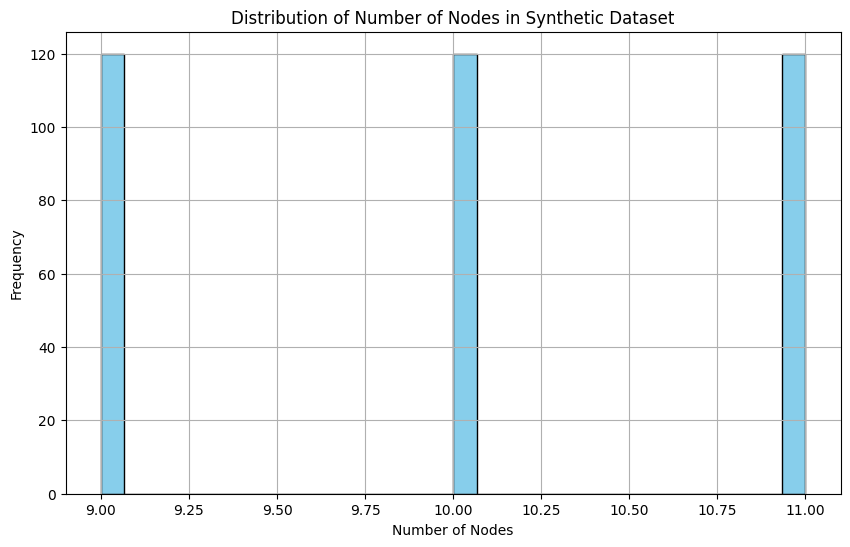

Small graphs: 360
Medium graphs: 0
Large graphs: 0


In [38]:
dataset = GraphDataset(torch.load("data/cycle_line_star_complete_1.pt"))
small_graphs, medium_graphs, large_graphs, classes = analyze_dataset(dataset)

In [39]:
def train(model, optimizer, pairs, labels, batch_size):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []

    def get_params(model):
        return {name: param.clone() for name, param in model.named_parameters()}

    initial_params = get_params(model)

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2, _, _, _, _ = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()
            # if i % 100 * batch_size == 0:
            #     print(
            #         f"Epoch: {i} - Loss: {batch_loss.item():.4f}, Acc: {batch_acc:.4f}"
            #     )

    trained_params = get_params(model)

    # for name in initial_params:
    #     initial_param = initial_params[name]
    #     trained_param = trained_params[name]
    #     if not torch.equal(initial_param, trained_param):
    #         print(f"Parameter {name} has changed.")
    #     else:
    #         print(f"Parameter {name} has NOT changed.")

    # plt.figure(figsize=(12, 5))

    # plt.subplot(1, 2, 1)
    # plt.plot(train_losses, label="Training Loss")
    # plt.title("Loss over Epochs")
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(train_accuracies, label="Training Accuracy")
    # plt.title("Accuracy over Epochs")
    # plt.xlabel("Epochs")
    # plt.ylabel("Accuracy")
    # plt.legend()

    # plt.show()

In [40]:
def test(model, title=""):
    class_clusters = []
    class_accs = []
    for i in range(4):
        c = f"class_{str(i)}"
        idx1 = random.sample(range(len(classes[c])), 1)[0]
        idx2 = random.sample(range(len(classes[c])), 1)[0]
        graph1, graph2 = classes[c][idx1], classes[c][idx2]

        model.eval()

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([len(graph1.x)])
        sizes_2 = torch.tensor([len(graph2.x)])
        model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)

        clusters = []
        accs = []
        entropies = []

        for i in range(len(model.topk_outputs)):
            (
                (x_pooled_1, edge_index_pooled_1, perm1),
                (x_pooled_2, edge_index_pooled_2, perm2),
            ) = model.topk_outputs[i]
            clusters.append(
                (
                    Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
                    Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
                )
            )
            accs.append(
                (
                    len(set(range(8)) & set(perm1.tolist())),
                    len(set(range(8)) & set(perm2.tolist())),
                )
            )

        acc = list(itertools.chain.from_iterable(zip(*accs)))
        class_accs.extend(acc)

        cs = list(itertools.chain.from_iterable(zip(*clusters)))
        class_clusters.extend(cs)
        # plot_graph_pair(cluster1, cluster2)

    # norm_barplot(model, 0)
    # norm_barplot(model, 1)
    # cross_barplot(model, 0)
    # cross_barplot(model, 1)
    plot_all_classes(class_clusters, class_accs, title, model.args.num_layers)

In [41]:
def acc_test(model, k_threshold=0.8, print_results=True):
    correct_class0 = 0
    correct_class1 = 0
    correct_class2 = 0
    correct_class3 = 0
    best_class0 = 0
    best_class1 = 0
    best_class2 = 0
    best_class3 = 0
    layers_class0 = []
    layers_class1 = []
    layers_class2 = []
    layers_class3 = []
    sims = []
    ks = []
    for _ in range(500):
        for i in range(4):
            c = f"class_{str(i)}"
            idx1 = random.sample(range(len(classes[c])), 1)[0]
            idx2 = random.sample(range(len(classes[c])), 1)[0]
            graph1, graph2 = classes[c][idx1], classes[c][idx2]

            model.eval()

            feats_1, edge_index_1 = graph1.x, graph1.edge_index
            feats_2, edge_index_2 = graph2.x, graph2.edge_index
            sizes_1 = torch.tensor([len(graph1.x)])
            sizes_2 = torch.tensor([len(graph2.x)])
            emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
                feats_1,
                edge_index_1,
                feats_2,
                edge_index_2,
                sizes_1,
                sizes_2,
                k_threshold,
            )

            if c == "class_0":
                layers_class0.append(layer1)
                layers_class0.append(layer2)
                # if not is_cycle(cluster1):
                #     plot_graph_pair(graph1, cluster1, c)
                # if not is_cycle(cluster2):
                #     plot_graph_pair(graph2, cluster2, c)
                correct_class0 += is_cycle(cluster1) + is_cycle(cluster2)
                best_class0 += any([is_cycle(cluster1), is_cycle(cluster2)])
            elif c == "class_1":
                layers_class1.append(layer1)
                layers_class1.append(layer2)
                # if not is_complete(cluster1):
                #     plot_graph_pair(graph1, cluster1, c)
                # if not is_complete(cluster2):
                #     plot_graph_pair(graph2, cluster2, c)
                correct_class1 += is_complete(cluster1) + is_complete(cluster2)
                best_class1 += any([is_complete(cluster1), is_complete(cluster2)])
            elif c == "class_2":
                layers_class2.append(layer1)
                layers_class2.append(layer2)
                # if not is_line(cluster1):
                #     plot_graph_pair(graph1, cluster1, c)
                # if not is_line(cluster2):
                #     plot_graph_pair(graph2, cluster2, c)
                correct_class2 += is_line(cluster1) + is_line(cluster2)
                best_class2 += any([is_line(cluster1), is_line(cluster2)])
            elif c == "class_3":
                layers_class3.append(layer1)
                layers_class3.append(layer2)
                # if not is_star(cluster1):
                #     plot_graph_pair(graph1, cluster1, c)
                # if not is_star(cluster2):
                #     plot_graph_pair(graph2, cluster2, c)
                correct_class3 += is_star(cluster1) + is_star(cluster2)
                best_class3 += any([is_star(cluster1), is_star(cluster2)])

    class0_acc = correct_class0 / 10
    class1_acc = correct_class1 / 10
    class2_acc = correct_class2 / 10
    class3_acc = correct_class3 / 10
    overall_acc = (class0_acc + class1_acc + class2_acc + class3_acc) / 4
    best_class0_acc = best_class0 / 5
    best_class1_acc = best_class1 / 5
    best_class2_acc = best_class2 / 5
    best_class3_acc = best_class3 / 5
    best_overall_acc = (
        best_class0_acc + best_class1_acc + best_class2_acc + best_class3_acc
    ) / 4
    # plot_layer_barplot(
    #     layers_class0, layers_class1, layers_class2, layers_class3, num_layers
    # )
    # unique, counts = np.unique(ks, return_counts=True)
    # counts = counts / sum(counts)
    # results = dict(zip(unique, counts))
    if print_results:
        print(f"Correct cycle predictions: {class0_acc:.1f}%")
        print(f"Correct complete predictions: {class1_acc:.1f}%")
        print(f"Correct line predictions: {class2_acc:.1f}%")
        print(f"Correct star predictions: {class3_acc:.1f}%")
        print(f"Overall accuracy: {overall_acc:.1f}%")
    return (class0_acc, class1_acc, class2_acc, class3_acc, overall_acc), (
        best_class0_acc,
        best_class1_acc,
        best_class2_acc,
        best_class3_acc,
        best_overall_acc,
    )

In [42]:
class NewArgs:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
        self.dim = dim
        self.feat_dim = dataset.num_features
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = dataset.num_classes
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = num_pairs

In [43]:
top_10 = [
    (32, 7, 0.5, 0.0001, 128, 3000),
    (32, 7, 0.2, 0.01, 64, 500),
    (32, 5, 0.2, 0.01, 32, 3000),
    (32, 8, 0.3, 0.0001, 64, 1000),
    (32, 7, 0.5, 0.01, 32, 3000),
    (32, 7, 0.4, 0.0001, 32, 500),
    (32, 5, 0.1, 0.01, 64, 3000),
    (32, 7, 0.4, 0.0001, 128, 3000),
    (32, 7, 0.5, 0.01, 128, 1000),
    (32, 8, 0.3, 0.0001, 64, 500),
]

In [44]:
for hyperparams in top_10:
    print(hyperparams)
    newargs = NewArgs(*hyperparams)
    model = GraphMatchingNetwork(newargs)
    optimizer = Adam(model.parameters(), lr=newargs.lr, weight_decay=1e-5)
    pairs, labels = create_graph_pairs(dataset, newargs.num_pairs)
    train(model, optimizer, pairs, labels, newargs.batch_size)
    acc_test(model, k_threshold=0.8)
    print("---")

(32, 7, 0.5, 0.0001, 128, 3000)
Correct cycle predictions: 72.4%
Correct complete predictions: 99.5%
Correct line predictions: 53.2%
Correct star predictions: 78.3%
Overall accuracy: 75.9%
---
(32, 7, 0.2, 0.01, 64, 500)
Correct cycle predictions: 70.6%
Correct complete predictions: 99.0%
Correct line predictions: 54.1%
Correct star predictions: 67.5%
Overall accuracy: 72.8%
---
(32, 5, 0.2, 0.01, 32, 3000)
Correct cycle predictions: 68.3%
Correct complete predictions: 94.0%
Correct line predictions: 44.7%
Correct star predictions: 71.7%
Overall accuracy: 69.7%
---
(32, 8, 0.3, 0.0001, 64, 1000)
Correct cycle predictions: 72.4%
Correct complete predictions: 98.4%
Correct line predictions: 57.7%
Correct star predictions: 79.2%
Overall accuracy: 76.9%
---
(32, 7, 0.5, 0.01, 32, 3000)
Correct cycle predictions: 70.8%
Correct complete predictions: 99.1%
Correct line predictions: 53.4%
Correct star predictions: 80.0%
Overall accuracy: 75.8%
---
(32, 7, 0.4, 0.0001, 32, 500)
Correct cycle pr

In [45]:
# model.eval()
# ks = []
# for _ in range(100):
#     c = f"class_0"
#     idx1 = random.sample(range(len(classes[c])), 1)[0]
#     idx2 = random.sample(range(len(classes[c])), 1)[0]
#     graph1, graph2 = classes[c][idx1], classes[c][idx2]

#     feats_1, edge_index_1 = graph1.x, graph1.edge_index
#     feats_2, edge_index_2 = graph2.x, graph2.edge_index
#     sizes_1 = torch.tensor([len(graph1.x)])
#     sizes_2 = torch.tensor([len(graph2.x)])
#     emb1, emb2, cluster1, cluster2, layer1, layer2, k = model(
#         feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
#     )

#     ks.append(k)

In [46]:
# acc_test(model, k_threshold=0.8)